# Non-tabular setting

`````{margin}
````{dropdown} Necessary imports
```{code-block} python
from matplotlib import pyplot as plt

from colosseum.agent.agents.infinite_horizon import (
    DQNContinuous,
    ActorCriticContinuous,
)
from colosseum.agent.utils import sample_agent_hyperparameters
from colosseum.benchmark import ColosseumDefaultBenchmark
from colosseum.emission_maps import (
    OneHotEncoding,
    StateLinearOptimal,
    StateLinearRandom,
    TensorEncoding,
    ImageEncoding,
    StateInfo,
)
from colosseum.experiment.agent_mdp_interaction import MDPLoop
from colosseum.mdp.simple_grid import SimpleGridContinuous
from colosseum.utils import make_mdp_spec
```
````
`````

In [1]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import tensorflow as tf

physical_devices = tf.config.list_physical_devices("GPU")
try:
    # Disable all GPUS
    tf.config.set_visible_devices([], "GPU")
    visible_devices = tf.config.get_visible_devices()
    for device in visible_devices:
        assert device.device_type != "GPU"
except:
    # Invalid device or cannot modify virtual devices once initialized.
    pass

from matplotlib import pyplot as plt

from colosseum.agent.agents.infinite_horizon import (
    DQNContinuous,
    ActorCriticContinuous,
)
from colosseum.agent.utils import sample_agent_hyperparameters
from colosseum.benchmark import ColosseumDefaultBenchmark
from colosseum.emission_maps import (
    OneHotEncoding,
    StateLinearOptimal,
    StateLinearRandom,
    TensorEncoding,
    ImageEncoding,
    StateInfo,
)
from colosseum.experiment.agent_mdp_interaction import MDPLoop
from colosseum.mdp.simple_grid import SimpleGridContinuous
from colosseum.utils import make_mdp_spec

{{col}} is primarily developed for the tabular {{rl}} setting.
However, as our goal is to develop principled non-tabular benchmarks, we offer a way to test non-tabular {{rl}}
algorithms on the default {{col}} benchmark. Although our benchmark defines a challenge that is well characterized for
tabular agents, we believe that it can provide valuable insights into the performance of non-tabular algorithms.

The _BlockMDP_ model `cite`{du2019provably} enables us to define non-tabular versions of tabular MDPs.
A BlockMDP is a tuple $\left(\mathcal S, \mathcal A, P, P_0, R, \mathcal O, q\right)$, where
$\mathcal S$ is the tabular state space,
$\mathcal A$ is the action space,
$P$ is the transition kernel,
$P_0$ is the starting state distribution,
$R$ is the reward kernel,
$\mathcal O$ is the non-tabular observation space, and
$q : \mathcal S \to \Delta(\mathcal O)$ is a (possibly stochastic) _emission map_ that associates a distribution over the observation
space to each state in the MDP.
Note that the agent is not provided with any information on the state space $\mathcal S$.

Six deterministic emission maps are available. We present them below for the
[``SimpleGridContinuous``](../pdoc_files/colosseum/mdp/simple_grid/base.html#SimpleGridContinuous) MDP class.

**One-hot encoding**
The [`OneHotEncoding`](../pdoc_files/colosseum/emission_maps/one_hot_encoding.html#OneHotEncoding) emission map assigns
to each state a feature vector that is filled with zeros except an index that uniquely corresponds to the state.

In [2]:
mdp = SimpleGridContinuous(seed=42, size=4, emission_map=OneHotEncoding)
ts = mdp.reset()

print("Observation for the OneHotEncoding emission map.")
print(ts.observation)

Observation for the OneHotEncoding emission map.
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


**Linear optimal value**
The [`StateLinearOptimal`](../pdoc_files/colosseum/emission_maps/state_linear_optimal.html#StateLinearOptimal)
emission map assigns to each state a feature vector $\phi(s)$ that enables linear representation of the optimal value
function. In other words, there is a $\theta$ such that $V^*(s) = \theta^T\phi(s)$.

In [3]:
mdp = SimpleGridContinuous(seed=42, size=4, emission_map=StateLinearOptimal)
ts = mdp.reset()

print("Observation for the StateLinearOptimal emission map.")
print(ts.observation.round(2))

Observation for the StateLinearOptimal emission map.
[[ 0.25  0.09  0.1   0.31  0.06  0.21 -0.39  0.22 -0.04 -0.07]]


**Linear random value**
The [`StateLinearRandom`](../pdoc_files/colosseum/emission_maps/state_linear_random.html#StateLinearRandom)
emission map assigns to each state a feature vector $\phi(s)$ that enables linear representation of the value function
of the randomly acting policy. In other words, there is a $\theta$ such that $V^\pi(s) = \theta^T\phi(s)$, where $\pi$
is the randomly acting policy.

In [4]:
mdp = SimpleGridContinuous(seed=42, size=4, emission_map=StateLinearRandom)
ts = mdp.reset()

print("Observation for the StateLinearRandom emission map.")
print(ts.observation.round(2))

Observation for the StateLinearRandom emission map.
[[ 0.25 -0.19 -0.23 -0.51 -0.09  0.14  0.49  0.04 -0.44  0.27]]


Before presenting the `StateInfo`, `ImageEncoding`, and `TensorEncoding` emission maps, we review the textual
representation of the `SimpleGridContinuous`, which is used by those emission maps.

In [5]:
mdp = SimpleGridContinuous(seed=42, size=4)
mdp.reset()
print("Textual representation.")
print(mdp.get_grid_representation(mdp.cur_node))

Textual representation.
[['+' ' ' ' ' '-']
 [' ' 'A' ' ' ' ']
 [' ' ' ' ' ' ' ']
 ['-' ' ' ' ' '+']]


The letter A encodes the position of the agent and the symbols $+$ and $-$
represent the states that yield large reward and zero reward.

**State information**
The [`StateInfo`](../pdoc_files/colosseum/emission_maps/state_info.html#StateInfo) emission map assigns to each state
a feature vector that contains uniquely identifying information about the state (e.g., coordinates for the DeepSea family).

In [6]:
mdp = SimpleGridContinuous(seed=42, size=4, emission_map=StateInfo)
ts = mdp.reset()

print("Observation for the StateInfo emission map.")
print(ts.observation)

Observation for the StateInfo emission map.
[[1. 2.]]


The observation vector corresponds to the x and y coordinates of the position of the agent.

**Image encoding**  
The [`ImageEncoding`](../pdoc_files/colosseum/emission_maps/image_encoding.html#ImageEncoding) emission map assigns to
each state a feature vector that contains uniquely identifying information about the state (e.g., coordinates for the
`DeepSea` mdp class).

In [7]:
mdp = SimpleGridContinuous(seed=42, size=4, emission_map=ImageEncoding)
ts = mdp.reset()

print("Observation for the ImageEncoding emission map.")
print(ts.observation)

Observation for the ImageEncoding emission map.
[[[2. 0. 0. 3.]
  [0. 1. 0. 0.]
  [0. 0. 0. 0.]
  [3. 0. 0. 2.]]]


In the observation matrix, $1$ corresponds to the position of the agent, $2$ to positive rewarding states, and $3$ to
non-rewarding states. The rest of the matrix is filled with zeros.

**Tensor encoding**
The [`TensorEncoding`](../pdoc_files/colosseum/emission_maps/tensor_encoding.html#TensorEncoding) emission map assigns
to each state a tensor composed of the concatenation of matrices that one-hot encode the presence of a symbol in the
corresponding indices. For example, for the DeepSea family, the tensor is composed of a matrix that encodes the position
of the agent and a matrix that encodes the positions of white spaces.

In [8]:
mdp = SimpleGridContinuous(seed=42, size=4, emission_map=TensorEncoding)
ts = mdp.reset()

print("Observation for the TensorEncoding emission map.")
print(ts.observation)

Observation for the TensorEncoding emission map.
[[[[0. 0. 1. 0.]
   [1. 0. 0. 0.]
   [1. 0. 0. 0.]
   [0. 0. 0. 1.]]

  [[1. 0. 0. 0.]
   [0. 1. 0. 0.]
   [1. 0. 0. 0.]
   [1. 0. 0. 0.]]

  [[1. 0. 0. 0.]
   [1. 0. 0. 0.]
   [1. 0. 0. 0.]
   [1. 0. 0. 0.]]

  [[0. 0. 0. 1.]
   [1. 0. 0. 0.]
   [1. 0. 0. 0.]
   [0. 0. 1. 0.]]]]


Similarly to the ImageEncoding emission map, each element of the textual representation is encoded differently.
In the TensorEncoding emission map, a one-hot encoding is used.


## Non-tabular agent/MDP interactions
Analysing the performances of non-tabular agents follows the same API of the tabular case.
We present an example below.

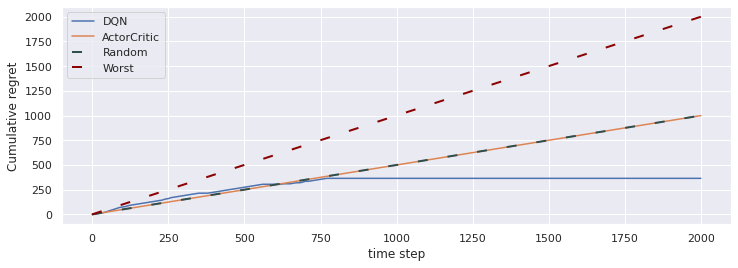

In [9]:
seed = 1
optimization_horizon = 2_000

# Instantiate the MDP
mdp = SimpleGridContinuous(seed=42, size=4, emission_map=TensorEncoding)

# DQN
boot_dqn = DQNContinuous(
    seed=seed,
    mdp_specs=make_mdp_spec(mdp),
    optimization_horizon=optimization_horizon,
    **sample_agent_hyperparameters(DQNContinuous, seed),
)

# Perform the agent/MDP interaction
loop_dqn = MDPLoop(mdp, boot_dqn)
loop_dqn.run(T=optimization_horizon, log_every=10)

# ActorCritic
actor_critic = ActorCriticContinuous(
    mdp_specs=make_mdp_spec(mdp),
    seed=seed,
    optimization_horizon=optimization_horizon,
    **sample_agent_hyperparameters(ActorCriticContinuous, seed),
)
loop_ac = MDPLoop(mdp, actor_critic)
loop_ac.run(T=optimization_horizon, log_every=10)

# Plot the cumulative regret of the agents
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
loop_dqn.plot(ax=ax, baselines=[])
loop_ac.plot(ax=ax)
plt.show()

## Non-tabular hyperparameters optimization and benchmarking
Similarly, the hyperparameters optimization and benchmarking procedures for the non-tabular setting can be carried out
in the exact same way as for the tabular case.

In order to obtain the default {{col}} benchmarks, it is only required to set `non_tabular=True` when calling the
`get_benchmark` function as shown below.
```{code-block} python
ColosseumDefaultBenchmark.CONTINUOUS_ERGODIC.get_benchmark(
    "non_tabular_ce", non_tabular=True
)
```